# Code to Explore Regressions / Other Data Analysis

- regression to see the most successful position on the court based on x and y coordinates
- look at offensively successful teams, is there a relation to the area they are shooting from

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

In [ ]:
df = pd.read_csv('combined_data.csv')

NameError: name 'pd' is not defined

# Regression of Location and Shot Success

In [1]:
#filter to only data with x and y
df_shots = df[df['shooting_play'] == True].dropna(subset=['shot_x', 'shot_y', 'scoring_play'])

#encode scoring, 1 = made, 0= missed
df_shots['made'] = df_shots['scoring_play'].astype(int)

X = df_shots[['shot_x', 'shot_y']]
y = df_shots['made']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_shots, x='shot_x', y='shot_y', hue='made', alpha=0.6, palette='coolwarm')


x_range = np.linspace(df_shots['shot_x'].min(), df_shots['shot_x'].max(), 100)
y_range = np.linspace(df_shots['shot_y'].min(), df_shots['shot_y'].max(), 100)
xx, yy = np.meshgrid(x_range, y_range)
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)


plt.contourf(xx, yy, probs, 25, cmap="coolwarm", alpha=0.3)
plt.colorbar(label='Probability of Scoring')
plt.title("Probability of Successful Shot by Location")
plt.xlabel("Shot X Coordinate")
plt.ylabel("Shot Y Coordinate")
plt.show()


NameError: name 'df' is not defined

# ML Model to Predict Shot Success

In [ ]:
#filter for only shots
df_shots = df[df['shooting_play'] == True].dropna(subset=[
    'play_team', 'secs_left_reg', 'is_three', 'is_assisted',
    'shot_x', 'shot_y', 'scoring_play'
])


df_shots['made'] = df_shots['scoring_play'].astype(int)


features = ['play_team', 'secs_left_reg', 'is_three', 'is_assisted', 'shot_x', 'shot_y']
X = df_shots[features]
y = df_shots['made']


categorical_features = ['play_team']
numeric_features = ['secs_left_reg', 'is_three', 'is_assisted', 'shot_x', 'shot_y']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       921
           1       0.82      0.67      0.74       682

    accuracy                           0.80      1603
   macro avg       0.80      0.78      0.79      1603
weighted avg       0.80      0.80      0.79      1603

ROC AUC Score: 0.8597923651774655


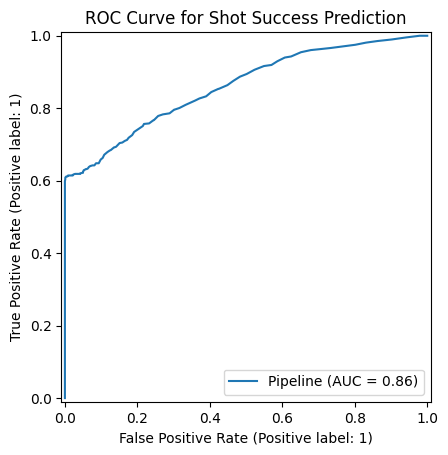

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("ROC Curve for Shot Success Prediction")
plt.show()


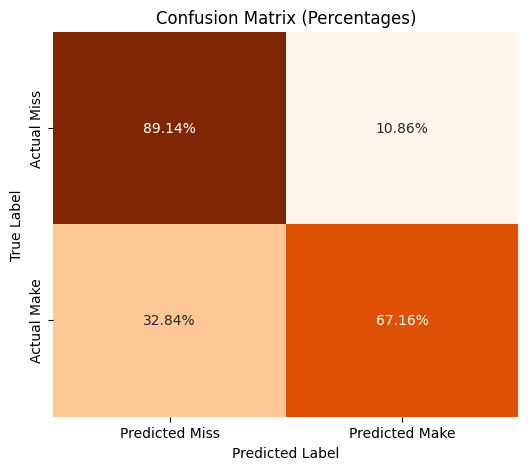

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges', cbar=False,
            xticklabels=['Predicted Miss', 'Predicted Make'],
            yticklabels=['Actual Miss', 'Actual Make'])
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### feature importance

<ipython-input-5-b9e4833526a0>:20: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


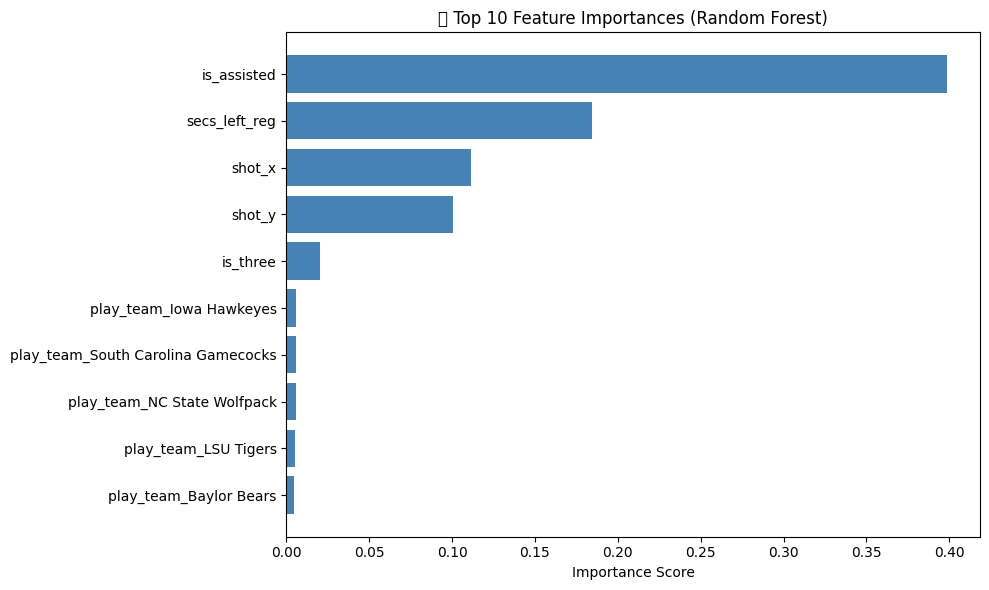

In [ ]:
feature_names_cat = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(['play_team'])
feature_names_all = np.concatenate([feature_names_cat, numeric_features])


importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 10
top_features = feature_names_all[indices][:top_n]
top_importances = importances[indices][:top_n]


plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1], color='steelblue')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Importance Score")
plt.title("🔝 Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [ ]:
total_importance = np.sum(importances)
top_5_importance = np.sum(top_importances[:5])
top_5_percentage = (top_5_importance / total_importance) * 100

print(f"Top 5 features account for {top_5_percentage:.2f}% of the total feature importance.")


Top 5 features account for 81.48% of the total feature importance.
